In [1]:
%cd ..

c:\Users\esper\Desktop\injury_forecasting


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.plotting import set_plot_style, plot_forecast_results, plot_top_k_feature_importances
import src.arima_utils as arima_utils 
from src.models_utils import *
from src.config import DATA_DIR, RESULTS_DIR, FIGURES_DIR


In [4]:
set_plot_style()

In [5]:
df = pd.read_csv(DATA_DIR / "processed" / "federal_df.csv", parse_dates=['EventDate'], low_memory=False)

## Monthly National time series - Hospitalization
### Classical statistical models: ETS, ARIMA, SARIMA

In [6]:
monthly_global = aggregate_time_series(
    df,
    date_col="EventDate",
    target_cols=["Hospitalized", "Amputation"],
    freq="MS",
    agg="sum",   # counts per month
)

# Focus on the hospitalized global series for now
monthly_hosp = monthly_global["Hospitalized"]


In [9]:
print(monthly_hosp.head())

EventDate
2015-01-01    673
2015-02-01    623
2015-03-01    664
2015-04-01    612
2015-05-01    611
Freq: MS, Name: Hospitalized, dtype: int64


In [10]:

monthly_hosp_train = monthly_hosp.loc[: "2023-12-01"]

# 2. ARIMA order search (non-seasonal)
arima_results, best_arima_order = arima_utils.find_best_arima(
    y=monthly_hosp_train,
    ic="aic",
)

print("Best ARIMA order:", best_arima_order)
print(arima_results.head())

# 3. SARIMA order search (seasonal with yearly period m=12)
sarima_results, best_order, best_seasonal_order = arima_utils.find_best_sarima(
    y=monthly_hosp_train,
    ic="aic",
    m=12,
)

print("Best SARIMA order:", best_order)
print("Best seasonal order:", best_seasonal_order)
print(sarima_results.head())


Best ARIMA order: (3, 1, 3)
       order seasonal_order          aic          bic
0  (3, 1, 3)           None  1160.171594  1178.614697
1  (0, 1, 3)           None  1161.059571  1171.598486
2  (1, 1, 3)           None  1162.863519  1176.037164
3  (2, 1, 3)           None  1163.539973  1179.348347
4  (0, 2, 3)           None  1163.795417  1174.295308
Best SARIMA order: (0, 1, 2)
Best seasonal order: (0, 1, 1, 12)
       order seasonal_order         aic         bic
0  (0, 1, 2)  (0, 1, 1, 12)  877.446780  886.974887
1  (1, 1, 2)  (0, 1, 1, 12)  878.772180  890.682313
2  (0, 1, 2)  (1, 1, 1, 12)  879.435711  891.345844
3  (1, 1, 2)  (1, 1, 1, 12)  880.748777  895.040936
4  (2, 1, 2)  (0, 1, 1, 12)  880.993685  895.285844


In [21]:
results_ets_monthly = arima_utils.evaluate_ets(monthly_hosp, train_end="2023-12-01", strategy='rolling')

results_arima_monthly = arima_utils.evaluate_sarimax(
    monthly_hosp,
    order=(3, 1, 3),
    train_end="2023-12-01",
    strategy='rolling'
)

results_sarima_monthly = arima_utils.evaluate_sarimax(
    monthly_hosp,
    order=(0, 1, 2),
    seasonal_order=(0, 1, 1, 12),
    train_end="2023-12-01",
    strategy='rolling'
)

# Example: inspect metrics
print("ETS train:", results_ets_monthly["train_metrics"], "test:", results_ets_monthly["test_metrics"])
print("ARIMA train:", results_arima_monthly["train_metrics"], "test:", results_arima_monthly["test_metrics"])
print("SARIMA train:", results_sarima_monthly["train_metrics"], "test:", results_sarima_monthly["test_metrics"])



ETS train: {'MAE': np.float64(37.16541694458859), 'RMSE': np.float64(46.8360475753816)} test: {'MAE': np.float64(22.285602120807397), 'RMSE': np.float64(29.82753410725837)}
ARIMA train: {'MAE': np.float64(59.892397971448815), 'RMSE': np.float64(93.91074581985667)} test: {'MAE': np.float64(39.695699654390125), 'RMSE': np.float64(49.894240474300446)}
SARIMA train: {'MAE': np.float64(54.99165932213642), 'RMSE': np.float64(94.34896875169709)} test: {'MAE': np.float64(23.086646535564075), 'RMSE': np.float64(30.45567921268526)}


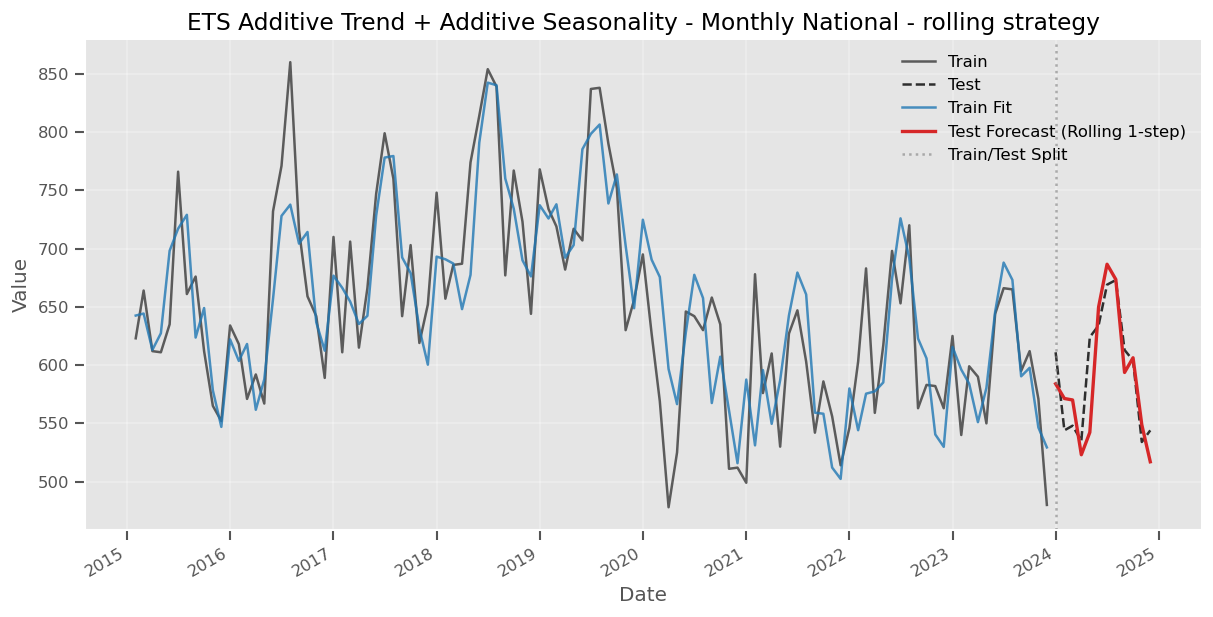

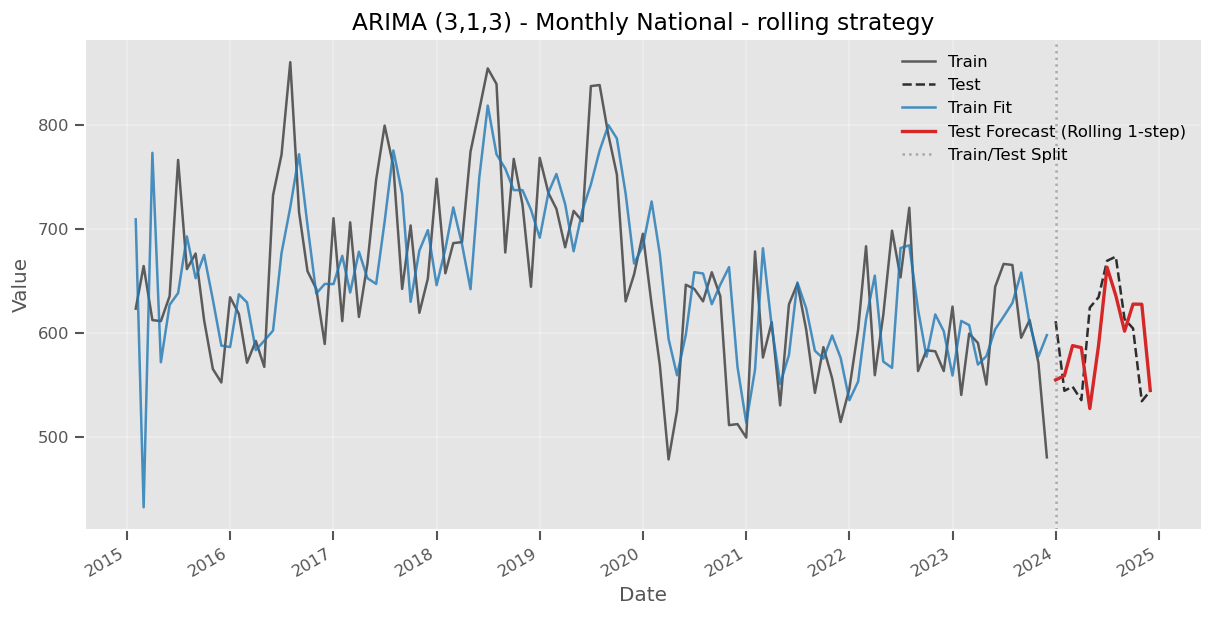

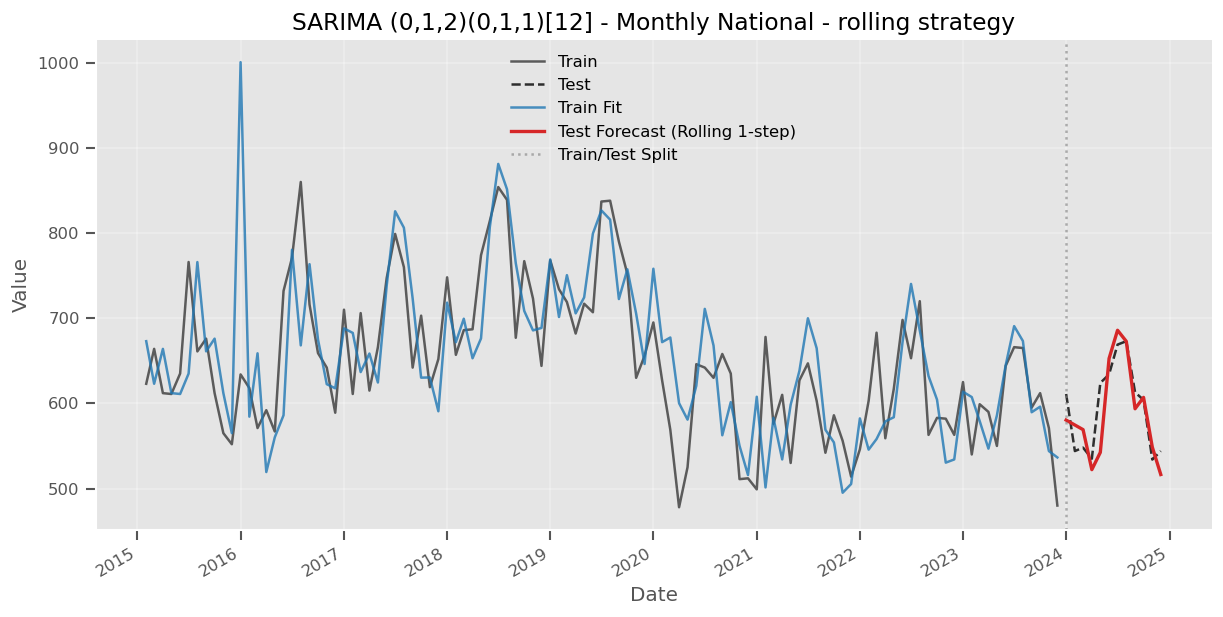

In [22]:
plot_forecast_results(results_ets_monthly, title="ETS Additive Trend + Additive Seasonality - Monthly National - rolling strategy")
plot_forecast_results(results_arima_monthly, title="ARIMA (3,1,3) - Monthly National - rolling strategy")
plot_forecast_results(results_sarima_monthly, title="SARIMA (0,1,2)(0,1,1)[12] - Monthly National - rolling strategy")


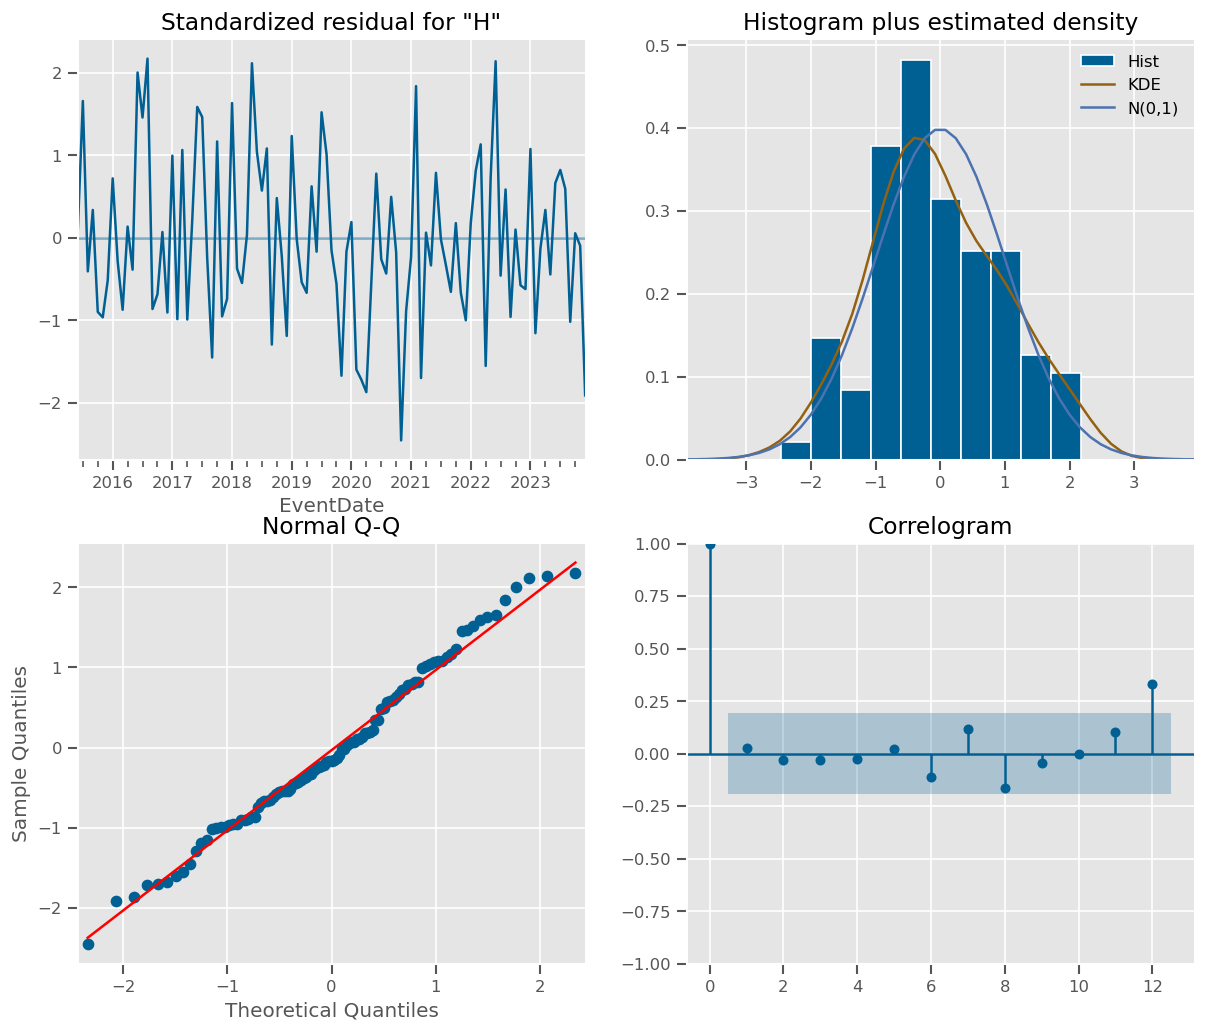

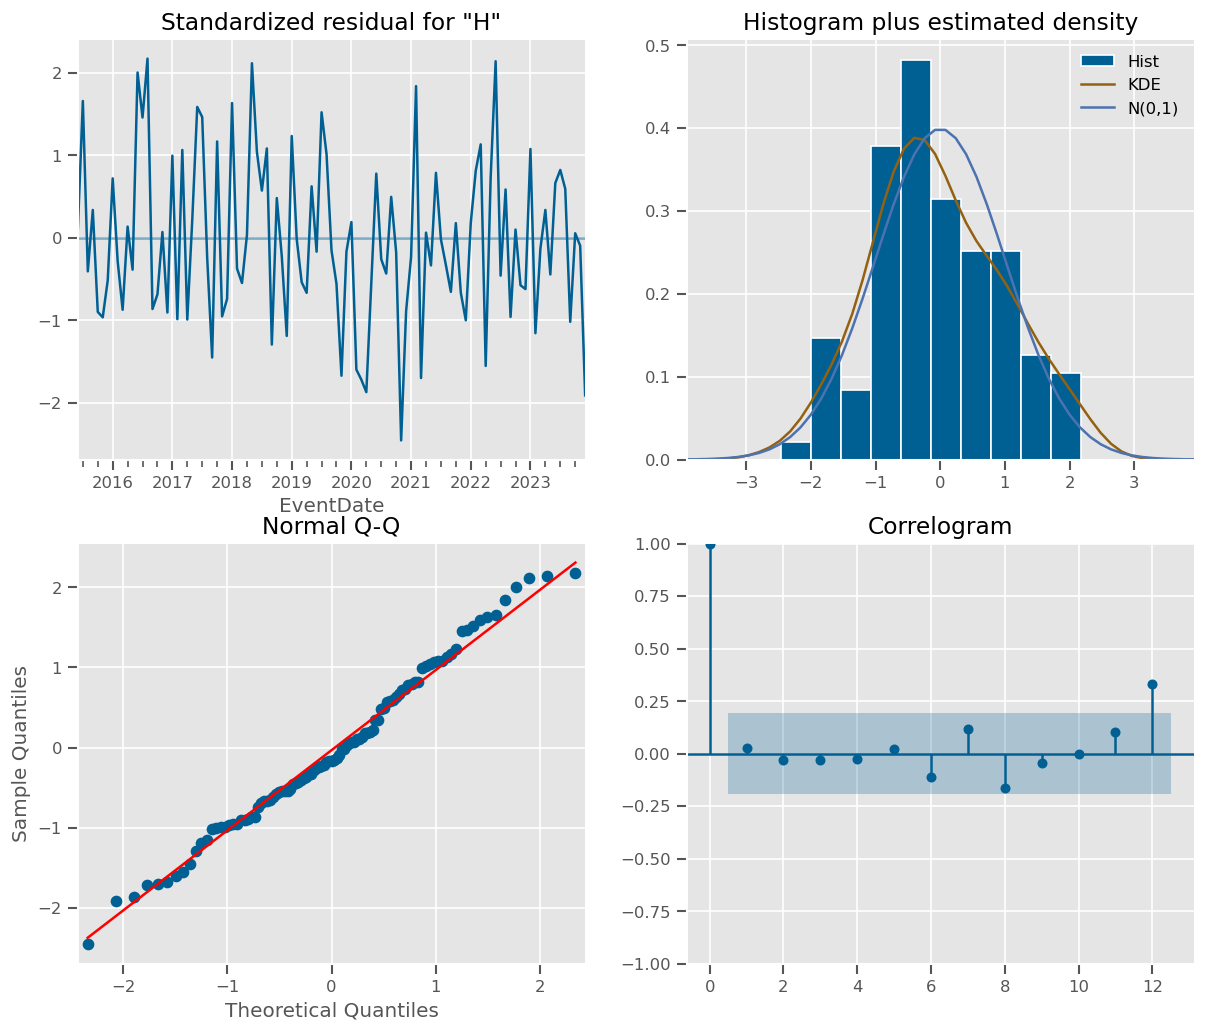

In [26]:
fit_arima = results_arima_monthly['fit']
fit_arima.plot_diagnostics(lags=12, figsize=(12, 10 ))

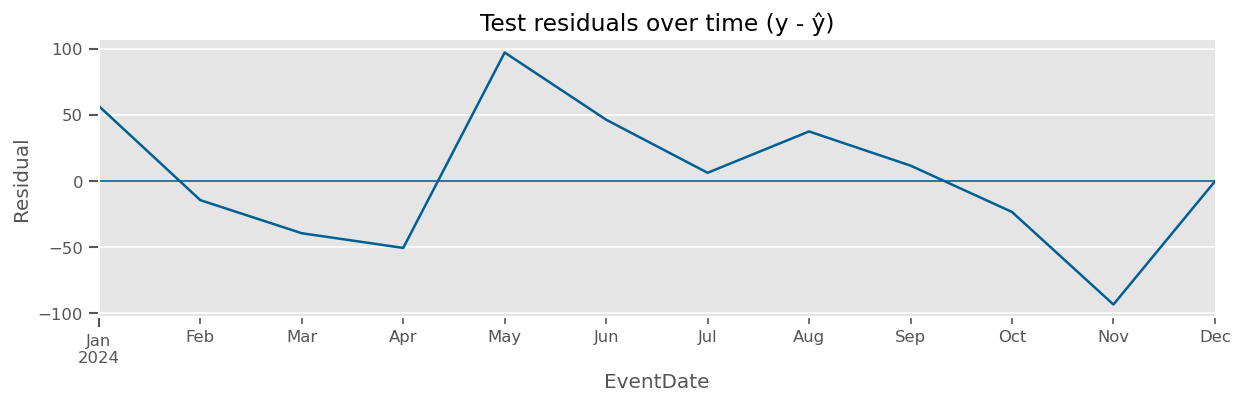

In [29]:
y_test_arima = results_arima_monthly["test_true"]
y_pred_arima = results_arima_monthly["test_pred"]

resid_test_arima = (y_test_arima - y_pred_arima).dropna()

fig, ax = plt.subplots(figsize=(12, 3))
resid_test_arima.plot(ax=ax)
ax.axhline(0, linewidth=1)
ax.set_title("Test residuals over time (y - ŷ)")
ax.set_ylabel("Residual")
plt.show()

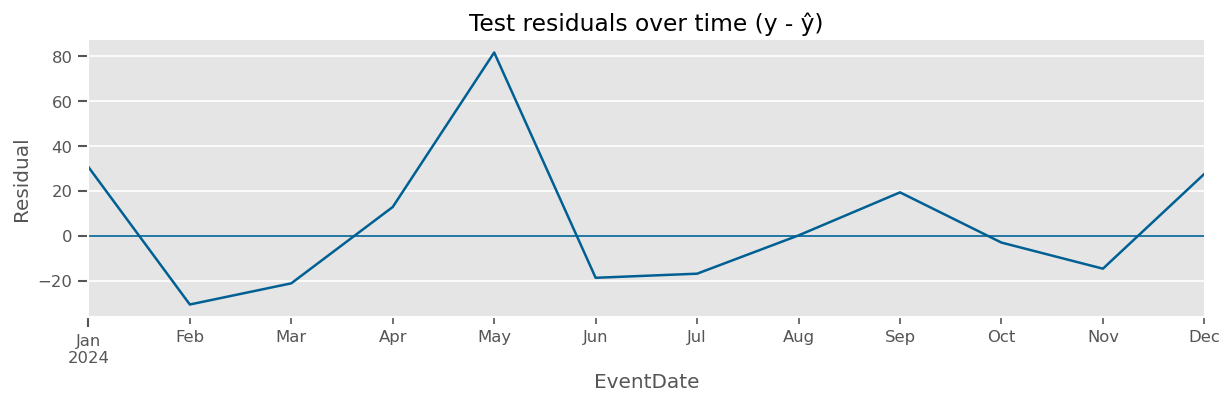

In [30]:
y_test_sarima = results_sarima_monthly["test_true"]
y_pred_sarima = results_sarima_monthly["test_pred"]

resid_test_sarima = (y_test_sarima - y_pred_sarima).dropna()

fig, ax = plt.subplots(figsize=(12, 3))
resid_test_sarima.plot(ax=ax)
ax.axhline(0, linewidth=1)
ax.set_title("Test residuals over time (y - ŷ)")
ax.set_ylabel("Residual")
plt.show()

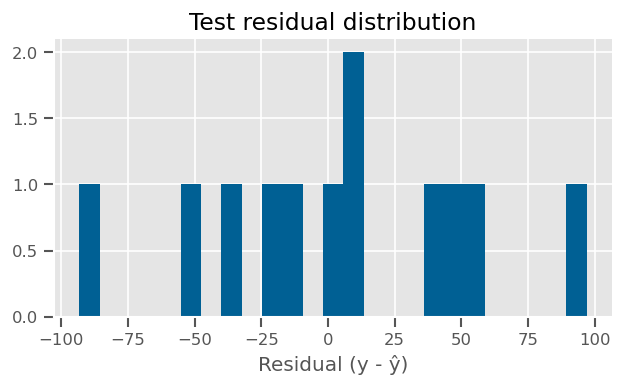

mean: 2.804998758288775
median: 2.937778277599648
std: 52.03041643088101


In [31]:
fig, ax = plt.subplots(figsize=(6, 3))
resid_test_arima.hist(ax=ax, bins=25)
ax.set_title("Test residual distribution")
ax.set_xlabel("Residual (y - ŷ)")
plt.show()

print("mean:", float(resid_test_arima.mean()))
print("median:", float(resid_test_arima.median()))
print("std:", float(resid_test_arima.std()))

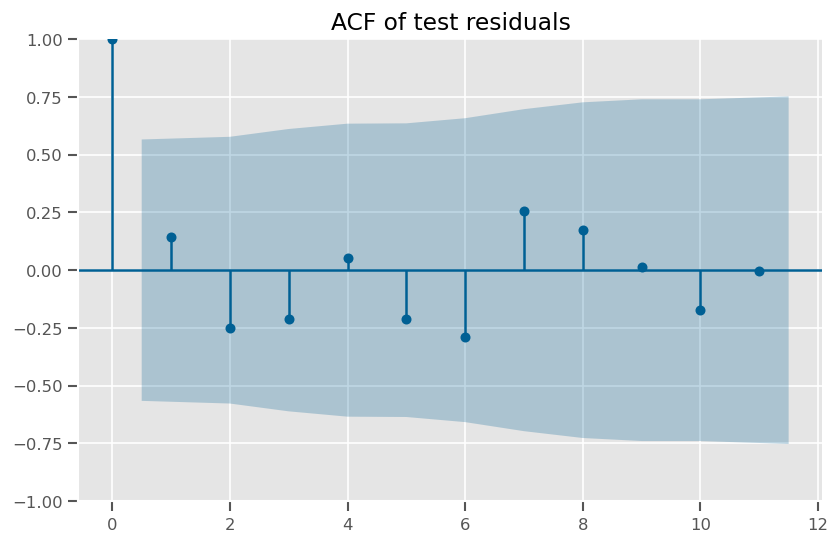

In [36]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(resid_test_arima, lags=11)
plt.title("ACF of test residuals")
plt.show()

In [15]:
all_results_monthly_classical_rolling = [
    results_arima_monthly,
    results_ets_monthly,
    results_sarima_monthly
]

df_monthly_classical_rolling = arima_utils.results_to_df(all_results_monthly_classical_rolling)
arima_utils.save_results_csv(df_monthly_classical_rolling, RESULTS_DIR / "national_monthly", filename='classical_rolling.csv')





Saved results to: C:\Users\esper\Desktop\injury_forecasting\results\national_monthly\classical_rolling.csv


### ETS, ARIMA, SARIMA with multistep forecasting strategy

In [37]:
results_ets_monthly_ms = arima_utils.evaluate_ets(monthly_hosp, train_end="2023-12-01", strategy='multistep')

results_arima_monthly_ms = arima_utils.evaluate_sarimax(
    monthly_hosp,
    order=(3, 1, 3),
    train_end="2023-12-01",
    strategy='multistep'
)

results_sarima_monthly_ms = arima_utils.evaluate_sarimax(
    monthly_hosp,
    order=(0, 1, 2),
    seasonal_order=(0, 1, 1, 12),
    train_end="2023-12-01",
    strategy='multistep'
)

# Example: inspect metrics
print("ETS train:", results_ets_monthly_ms["train_metrics"], "test:", results_ets_monthly_ms["test_metrics"])
print("ARIMA train:", results_arima_monthly_ms["train_metrics"], "test:", results_arima_monthly_ms["test_metrics"])
print("SARIMA train:", results_sarima_monthly_ms["train_metrics"], "test:", results_sarima_monthly_ms["test_metrics"])

ETS train: {'MAE': np.float64(37.16541694458859), 'RMSE': np.float64(46.8360475753816)} test: {'MAE': np.float64(22.92543654056216), 'RMSE': np.float64(30.50585677179016)}
ARIMA train: {'MAE': np.float64(59.892397971448815), 'RMSE': np.float64(93.91074581985667)} test: {'MAE': np.float64(49.34882943520602), 'RMSE': np.float64(54.46048211000886)}
SARIMA train: {'MAE': np.float64(54.99165932213642), 'RMSE': np.float64(94.34896875169709)} test: {'MAE': np.float64(23.597156727296106), 'RMSE': np.float64(31.051361883439917)}


In [17]:
all_results_monthly_classical_multistep = [
    results_arima_monthly_ms,
    results_ets_monthly_ms,
    results_sarima_monthly_ms
]

df_monthly_classical_multistep = arima_utils.results_to_df(all_results_monthly_classical_multistep)
arima_utils.save_results_csv(df_monthly_classical_multistep, RESULTS_DIR / "national_monthly", filename='classical_multistep.csv')





Saved results to: C:\Users\esper\Desktop\injury_forecasting\results\national_monthly\classical_multistep.csv


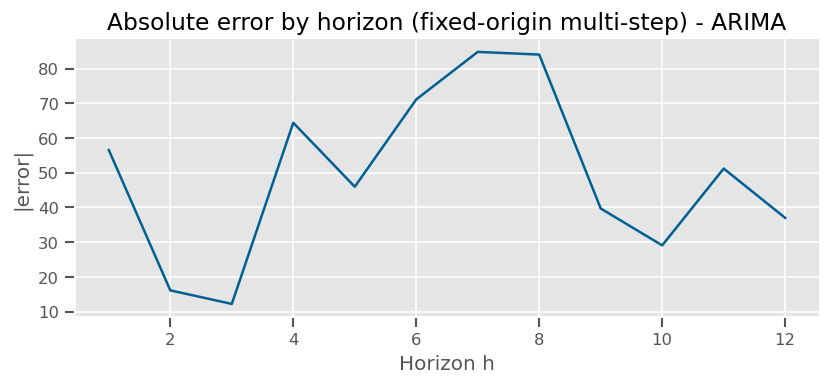

In [39]:
y_test_arima_ms = results_arima_monthly_ms["test_true"]
y_pred_arima_ms = results_arima_monthly_ms["test_pred"]

err = (y_test_arima_ms - y_pred_arima_ms).dropna().values
h = np.arange(1, len(err) + 1)

mae_by_h = np.abs(err)  # for fixed-origin, each h occurs once

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(h, mae_by_h)
ax.set_title("Absolute error by horizon (fixed-origin multi-step) - ARIMA")
ax.set_xlabel("Horizon h")
ax.set_ylabel("|error|")
plt.show()


## ML models / linear: Ridge, Lasso, ElasticNet, PLS

In [8]:
X_hosp, y_hosp_sup = build_feature_matrix(
    monthly_hosp,
    lags=(1, 2, 3, 6, 12),
    rolling_windows=(3, 6, 12),
    ewma_spans=(3, 6, 12),
    add_calendar=True,
)

In [9]:
train_end = "2023-12-01"

X_train = X_hosp.loc[:train_end]
y_train = y_hosp_sup.loc[:train_end]

test_end = "2024-12-01"
X_test = X_hosp.loc[train_end:test_end]
y_test = y_hosp_sup.loc[train_end:test_end]

print(y_test.index[0], y_test.index[-1])

2023-12-01 00:00:00 2024-12-01 00:00:00


In [40]:
linear_results_monthly = fit_evaluate_linear_models(X_train, y_train, X_test, y_test)


c:\Users\esper\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.207e+02, tolerance: 7.440e+01
  model = cd_fast.enet_coordinate_descent(


In [41]:
print(linear_results_monthly["Ridge"]["test_metrics"], linear_results_monthly["Lasso"]["test_metrics"], linear_results_monthly["ElasticNet"]["test_metrics"], linear_results_monthly["PLS"]["test_metrics"])


{'MAE': np.float64(26.066982004473655), 'RMSE': np.float64(33.45498042827608)} {'MAE': np.float64(25.01532941337991), 'RMSE': np.float64(33.3919513970851)} {'MAE': np.float64(25.419414622979623), 'RMSE': np.float64(33.18262403526122)} {'MAE': np.float64(25.381382920421263), 'RMSE': np.float64(33.01818684121434)}


In [24]:
all_linear_results_monthly = list(linear_results_monthly.values())
df_linear_monthly = arima_utils.results_to_df(all_linear_results_monthly)
arima_utils.save_results_csv(df_linear_monthly, save_dir=RESULTS_DIR / "national_monthly", filename="linear_models.csv")

Saved results to: C:\Users\esper\Desktop\injury_forecasting\results\national_monthly\linear_models.csv


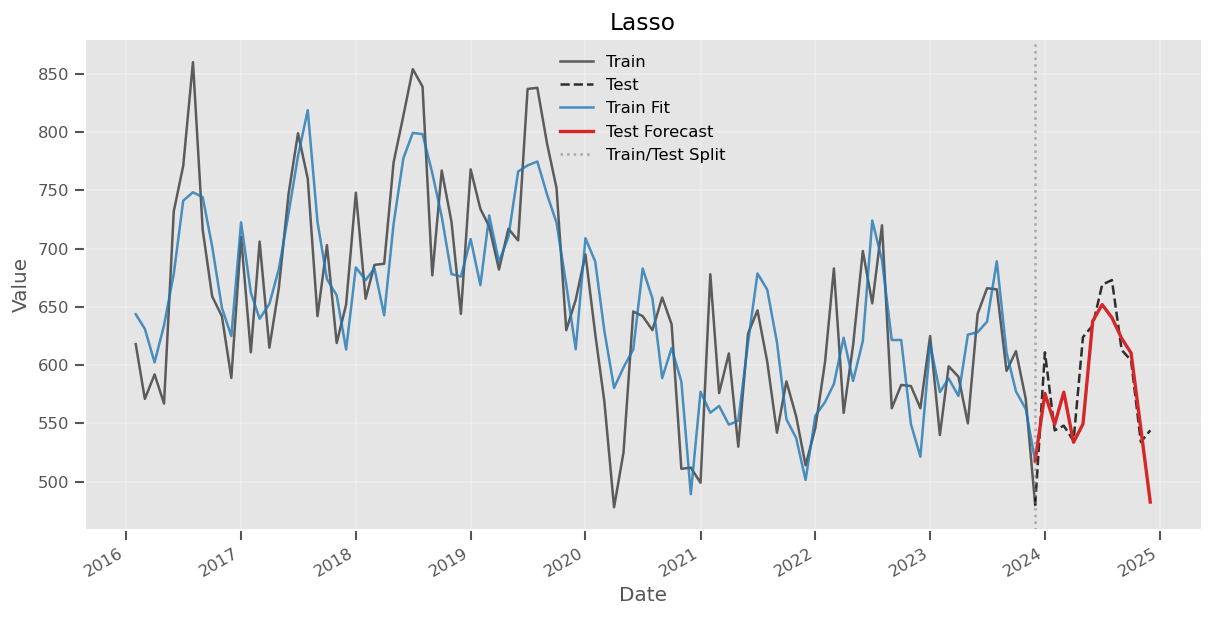

In [25]:
plot_forecast_results(linear_results_monthly["Lasso"])

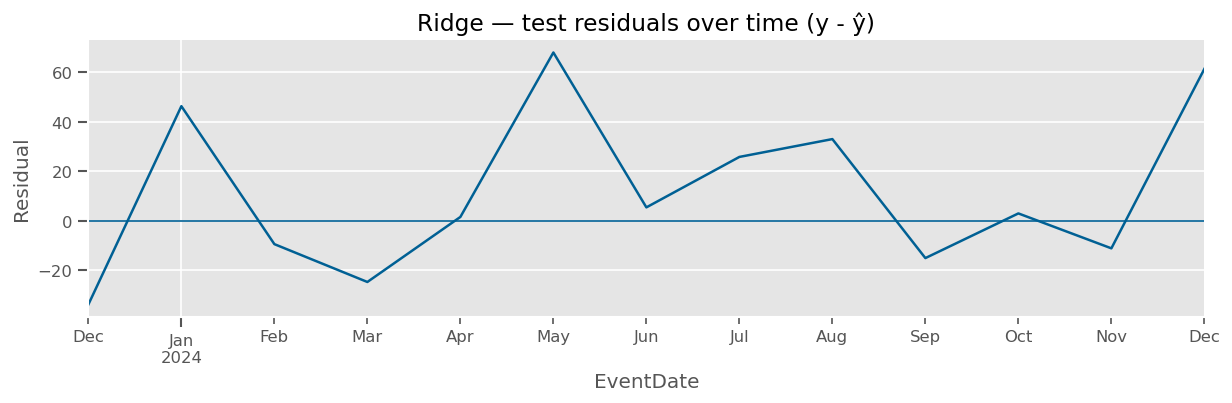

In [43]:
import matplotlib.pyplot as plt

y_test_ridge = linear_results_monthly["Ridge"]["test_true"]
y_pred_ridge = linear_results_monthly["Ridge"]["test_pred"]

resid_test_ridge = (y_test_ridge - y_pred_ridge).dropna()

fig, ax = plt.subplots(figsize=(12, 3))
resid_test_ridge.plot(ax=ax)
ax.axhline(0, linewidth=1)
ax.set_title("Ridge — test residuals over time (y - ŷ)")
ax.set_ylabel("Residual")
plt.show()


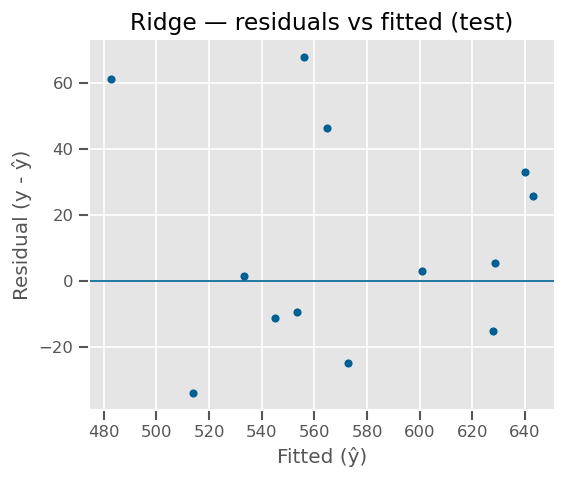

In [44]:


fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(y_pred_ridge.loc[resid_test_ridge.index], resid_test_ridge, s=15)
ax.axhline(0, linewidth=1)
ax.set_title("Ridge — residuals vs fitted (test)")
ax.set_xlabel("Fitted (ŷ)")
ax.set_ylabel("Residual (y - ŷ)")
plt.show()


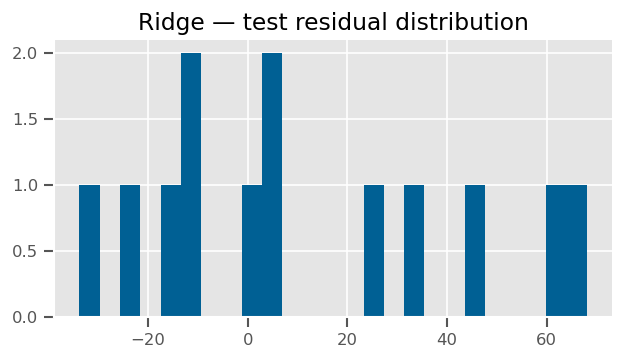

mean: 11.60985604358562 std: 32.657069749323554


In [45]:
fig, ax = plt.subplots(figsize=(6, 3))
resid_test_ridge.hist(ax=ax, bins=25)
ax.set_title("Ridge — test residual distribution")
plt.show()
print("mean:", float(resid_test_ridge.mean()), "std:", float(resid_test_ridge.std()))

## Tree-based ensemble models: XGBoost, LightGBM, CatBoost

In [7]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [10]:
tree_results_monthly = fit_evaluate_boosting_models(X_train, y_train, X_test, y_test)


In [31]:
df_tree_monthly = arima_utils.results_to_df(list(tree_results_monthly.values()))
arima_utils.save_results_csv(df_tree_monthly, save_dir=RESULTS_DIR / "national_monthly", filename="tree_models.csv")


Saved results to: C:\Users\esper\Desktop\injury_forecasting\results\national_monthly\tree_models.csv


In [11]:
importances = get_feature_importances(tree_results_monthly, X_train)

In [14]:
print(importances)

{'XGBoost': year           0.394287
ewma_3         0.173716
month_cos      0.098093
lag_12         0.069341
month          0.047264
month_sin      0.042310
rollmean_6     0.034577
rollmean_3     0.034540
lag_1          0.026175
rollmean_12    0.020989
lag_2          0.016346
lag_3          0.012928
ewma_6         0.012325
lag_6          0.009039
ewma_12        0.008070
quarter        0.000000
Name: XGBoost, dtype: float32, 'LightGBM': month          125
year           113
lag_12          99
rollmean_6      68
month_cos       60
lag_1           58
lag_3           55
month_sin       50
lag_6           48
ewma_3          46
lag_2           46
ewma_6          38
rollmean_3      14
rollmean_12      4
ewma_12          3
quarter          0
Name: LightGBM, dtype: int32, 'CatBoost': year           13.833561
month          12.327815
month_cos      11.381113
ewma_3          9.863526
lag_12          8.952982
month_sin       7.762660
lag_1           6.458807
lag_2           4.332025
ewma_6         

In [18]:
feat_imp_tree = pd.concat(
    {model: s for model, s in importances.items()},
    axis=1
)

feat_imp_tree


,XGBoost,LightGBM,CatBoost
year,0.394287,113,13.833561
ewma_3,0.173716,46,9.863526
month_cos,0.098093,60,11.381113
lag_12,0.069341,99,8.952982
month,0.047264,125,12.327815
month_sin,0.042310,50,7.762660
rollmean_6,0.034577,68,3.159251
rollmean_3,0.034540,14,3.082515
lag_1,0.026175,58,6.458807
rollmean_12,0.020989,4,3.706241


(<Figure size 1440x480 with 3 Axes>,
 array([<Axes: title={'center': 'XGBoost'}, xlabel='Importance'>,
        <Axes: title={'center': 'LightGBM'}, xlabel='Importance'>,
        <Axes: title={'center': 'CatBoost'}, xlabel='Importance'>],
       dtype=object))

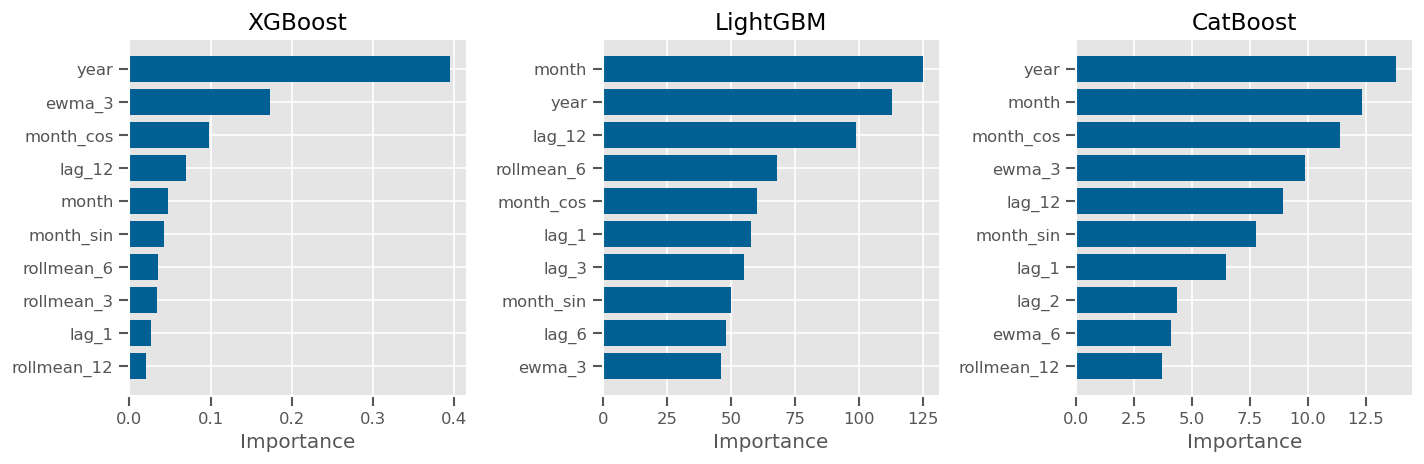

In [20]:
plot_top_k_feature_importances(feat_imp_tree, k=10)

In [14]:
weekly_national = aggregate_time_series(
    df,
    date_col="EventDate",
    freq="W-MON",
    agg="sum",
       target_cols=['Hospitalized']   # counts per week
)

weekly_national = weekly_national['Hospitalized']

In [15]:
weekly_national.tail(65)

EventDate
2023-12-11    128
2023-12-18    110
2023-12-25     80
2024-01-01     93
2024-01-08    114
             ... 
2025-02-03    138
2025-02-10    133
2025-02-17    164
2025-02-24    142
2025-03-03    108
Freq: W-MON, Name: Hospitalized, Length: 65, dtype: int64

In [17]:

weekly_hosp_train = weekly_national.loc[: "2023-12-25"]

# 2. ARIMA order search (non-seasonal)
arima_results_wk, best_arima_order_wk = arima_utils.find_best_arima(
    y=weekly_hosp_train,
    ic="aic",
)

print("Best ARIMA order:", best_arima_order_wk)
print(arima_results_wk.head())

# 3. SARIMA order search (seasonal with yearly period m=52)
sarima_results_wk, best_order_wk, best_seasonal_order_wk = arima_utils.find_best_sarima(
    y=weekly_hosp_train,
    ic="aic",
    m=52,
)

print("Best SARIMA order:", best_order_wk)
print("Best seasonal order:", best_seasonal_order_wk)
print(sarima_results_wk.head())

Best ARIMA order: (2, 1, 3)
       order seasonal_order          aic          bic
0  (2, 1, 3)           None  4152.180223  4177.019530
1  (3, 1, 3)           None  4154.173490  4183.152682
2  (0, 1, 3)           None  4155.686958  4172.246496
3  (0, 2, 3)           None  4156.411805  4172.962713
4  (1, 1, 3)           None  4157.516669  4178.216092


KeyboardInterrupt: 

In [23]:
results_ets_wk = arima_utils.evaluate_ets(weekly_national, train_end="2023-12-25", strategy='multistep')

results_arima_wk = arima_utils.evaluate_sarimax(
    weekly_national,
    order=(3, 1, 3),
    train_end="2023-12-25",
    strategy='multistep'
)

results_sarima_wk = arima_utils.evaluate_sarimax(
    weekly_national,
    order=(0, 1, 2),
    seasonal_order=(0, 1, 1, 52),
    train_end="2023-12-25",
    strategy='multistep'
)

# Example: inspect metrics
print("ETS train:", results_ets_wk["train_metrics"], "test:", results_ets_wk["test_metrics"])
print("ARIMA train:", results_arima_wk["train_metrics"], "test:", results_arima_wk["test_metrics"])
print("SARIMA train:", results_sarima_wk["train_metrics"], "test:", results_sarima_wk["test_metrics"])


ETS train: {'MAE': np.float64(16.91170824514419), 'RMSE': np.float64(21.504481604695524)} test: {'MAE': np.float64(26.625124021834264), 'RMSE': np.float64(31.64119843789201)}
ARIMA train: {'MAE': np.float64(16.684905077910656), 'RMSE': np.float64(21.98201547587183)} test: {'MAE': np.float64(23.22894049779142), 'RMSE': np.float64(28.214336393803883)}
SARIMA train: {'MAE': np.float64(16.571380393652316), 'RMSE': np.float64(21.330968716964858)} test: {'MAE': np.float64(15.143803080808045), 'RMSE': np.float64(18.99283376973135)}


In [38]:
all_results_weekly_classical_multistep = [
    results_arima_wk,
    results_ets_wk,
    results_sarima_wk
]

df_weekly_classical_multistep = arima_utils.results_to_df(all_results_weekly_classical_multistep)
arima_utils.save_results_csv(df_weekly_classical_multistep, RESULTS_DIR / "national_weekly", filename='classical_multistep.csv')





Saved results to: C:\Users\esper\Desktop\injury_forecasting\results\national_weekly\classical_multistep.csv


In [24]:
for name, res in [("ETS", results_ets_wk), ("ARIMA", results_arima_wk), ("SARIMA", results_sarima_wk)]:
    print(name)
    print("  test_true length:", len(res["test_true"]))
    print("  test_pred length:", len(res["test_pred"]))
    print("  test_true NaNs:", res["test_true"].isna().sum())
    print("  test_pred NaNs:", res["test_pred"].isna().sum())
    print("  index overlap:", len(res["test_true"].index.intersection(res["test_pred"].index)))
    print()


ETS
  test_true length: 53
  test_pred length: 53
  test_true NaNs: 0
  test_pred NaNs: 0
  index overlap: 53

ARIMA
  test_true length: 53
  test_pred length: 53
  test_true NaNs: 0
  test_pred NaNs: 0
  index overlap: 53

SARIMA
  test_true length: 53
  test_pred length: 53
  test_true NaNs: 0
  test_pred NaNs: 0
  index overlap: 53



In [ ]:


X_wk, y_wk= build_feature_matrix(
    weekly_national,
    lags=(1, 2, 3, 6, 12, 24, 52),
    rolling_windows=(3, 6, 12, 24),
    ewma_spans=(3, 6, 12, 24),
    add_calendar=True,
)

X_wk.head(), y_wk.head()


(            lag_1  lag_2  lag_3  lag_6  lag_12  lag_24  lag_52  rollmean_3  \
 EventDate                                                                    
 2016-01-04   83.0  124.0  152.0  158.0   138.0   173.0    66.0  119.666667   
 2016-01-11   95.0   83.0  124.0   78.0   145.0   163.0   171.0  100.666667   
 2016-01-18  147.0   95.0   83.0  141.0   128.0   210.0   148.0  108.333333   
 2016-01-25  173.0  147.0   95.0  152.0   141.0   163.0   162.0  138.333333   
 2016-02-01  154.0  173.0  147.0  124.0   146.0   161.0   160.0  158.000000   
 
             rollmean_6  rollmean_12  rollmean_24      ewma_3      ewma_6  \
 EventDate                                                                  
 2016-01-04  122.666667   132.416667   146.375000  107.541475  119.481070   
 2016-01-11  112.166667   128.833333   143.125000  101.270738  112.486478   
 2016-01-18  123.666667   129.000000   142.458333  124.135369  122.347485   
 2016-01-25  129.000000   132.750000   140.916667  148.56768

In [30]:
train_end = "2023-12-25"

X_train_wk = X_wk.loc[:train_end]
y_train_wk = y_wk.loc[:train_end]

test_end = "2024-12-30"
X_test_wk = X_wk.loc[train_end:test_end]
y_test_wk = y_wk.loc[train_end:test_end]

print(y_test_wk.index[0], y_test_wk.index[-1])

2023-12-25 00:00:00 2024-12-30 00:00:00


In [31]:
linear_results_weekly = fit_evaluate_linear_models(X_train_wk, y_train_wk, X_test_wk, y_test_wk)


In [36]:
print(linear_results_weekly["Ridge"]["test_metrics"], linear_results_weekly["Lasso"]["test_metrics"], linear_results_weekly["ElasticNet"]["test_metrics"], linear_results_weekly["PLS"]["test_metrics"])


{'MAE': np.float64(15.995164478096227), 'RMSE': np.float64(20.07043140736253)} {'MAE': np.float64(16.06628396989872), 'RMSE': np.float64(20.156190656128203)} {'MAE': np.float64(15.898568948379323), 'RMSE': np.float64(20.00767801338513)} {'MAE': np.float64(15.827958680835149), 'RMSE': np.float64(19.92753279719147)}


In [37]:


all_linear_results_weekly = list(linear_results_weekly.values())
df_linear_weekly = arima_utils.results_to_df(all_linear_results_weekly)
arima_utils.save_results_csv(df_linear_weekly, save_dir=RESULTS_DIR / "national_weekly", filename="linear_models.csv")

Saved results to: C:\Users\esper\Desktop\injury_forecasting\results\national_weekly\linear_models.csv


In [39]:
from src.arima_utils import evaluate_naive_persistence

In [42]:
results_naive = evaluate_naive_persistence(weekly_national, train_end= "2023-12-25")

In [43]:
print(results_naive["test_metrics"])

{'MAE': np.float64(18.849056603773583), 'RMSE': np.float64(25.881806825032555)}


In [46]:
results_naive_monthly = evaluate_naive_persistence(monthly_hosp, train_end= "2023-12-01")
print(results_naive_monthly["test_metrics"])

{'MAE': np.float64(41.833333333333336), 'RMSE': np.float64(57.57458930234182)}
